# Lorentz attractor

In [57]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import torch

import xarray as xr

import matplotlib.pyplot as plt
import seaborn as sns

import collections

import latenta as la
import ladynamic as lad

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [58]:
from latenta.variables import Variable

In [59]:
import networkx as nx

![](https://wikimedia.org/api/rest_v1/media/math/render/svg/7928004d58943529a7be774575a62ca436a82a7f)

In [103]:
class dx(la.Computed):
    y = la.variables.VariablePromise()
    x = la.variables.VariablePromise()
    sigma = la.variables.VariablePromise("sigma", r"\sigma")
    def __call__(self, sigma, y, x):
        return sigma * (y-x)
class dy(la.Computed):
    x = la.variables.VariablePromise()
    y = la.variables.VariablePromise()
    z = la.variables.VariablePromise()
    rho = la.variables.VariablePromise("rho", r"\rho")
    def __call__(self, rho, x, y, z):
        return x * (rho - z) - y
class dz(la.Computed):
    x = la.variables.VariablePromise()
    y = la.variables.VariablePromise()
    z = la.variables.VariablePromise()
    beta = la.variables.VariablePromise("beta", r"\beta")
    def __call__(self, beta, x, y, z):
        return x * y - beta * z

-----

In [104]:
x_initial = la.Fixed(1)
y_initial = la.Fixed(1)
z_initial = la.Fixed(1)

In [105]:
sigma = la.Fixed(10.)
beta = la.Fixed(8/3)
rho = la.Fixed(28.)

In [106]:
x = lad.State(x_initial, label = "x")
y = lad.State(y_initial, label = "y")
z = lad.State(z_initial, label = "z")

In [107]:
x.derivative = dx(y, x, sigma)
y.derivative = dy(x, y, z, rho)
z.derivative = dz(x, y, z, beta)

In [108]:
final_time = la.Fixed(50.)

x_extractor = lad.extractors.EachExtractor(x, final_time)
y_extractor = lad.extractors.EachExtractor(y, final_time)
z_extractor = lad.extractors.EachExtractor(z, final_time)

extractors = [x_extractor, y_extractor, z_extractor]

In [109]:
dt = la.Fixed(0.01)
states = [x, y, z]
dynamics = lad.solvers.Euler(states, extractors, dt)

In [110]:
time = dynamics.time
time_extractor = lad.extractors.EachExtractor(time, final_time)
dynamics.add_extractors(time_extractor)


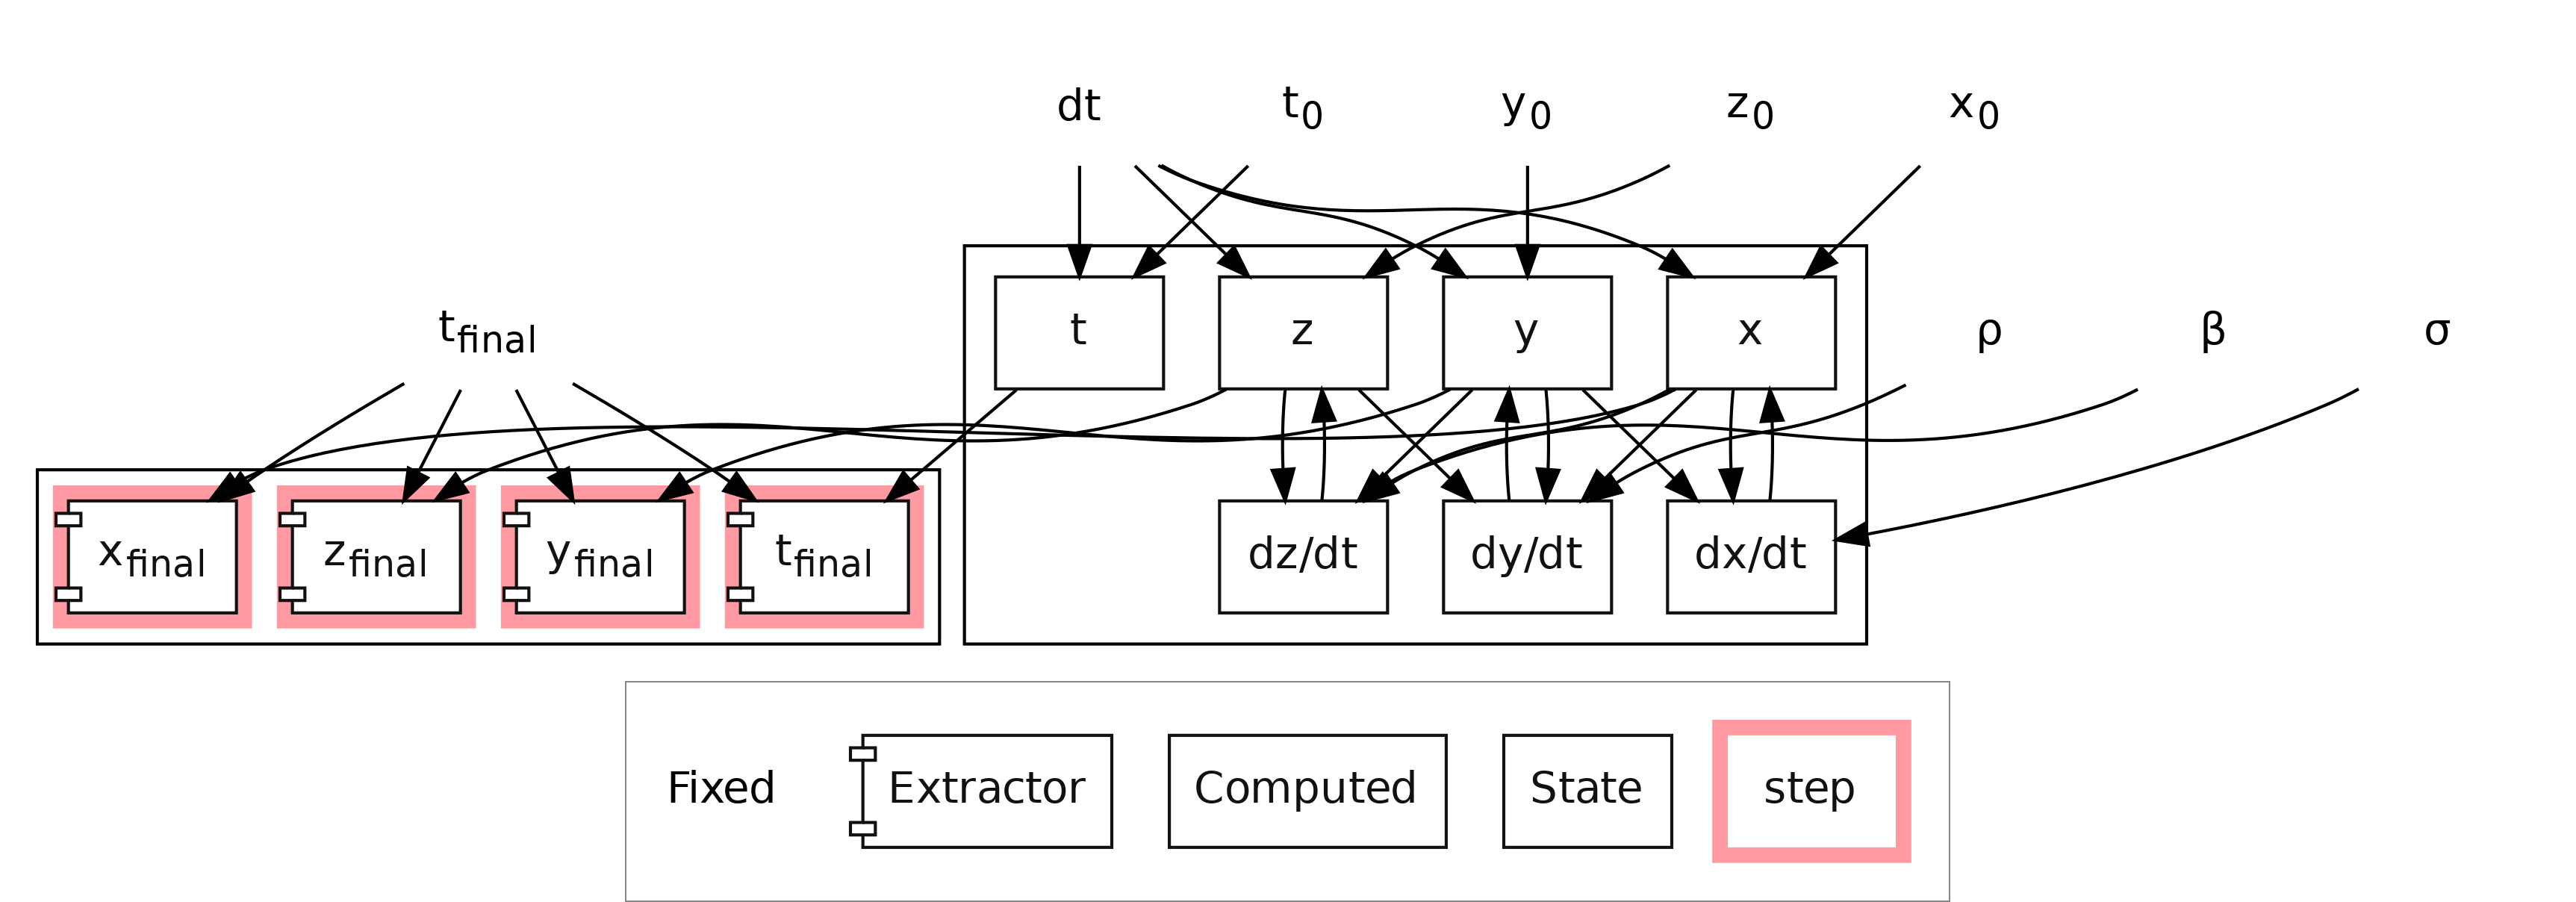

In [111]:
model = la.Model(x_extractor, y_extractor, z_extractor, time_extractor)
model.plot()

In [112]:
posterior = la.posterior.Posterior(model)
posterior.sample(1)

  0%|          | 0/1 [00:00<?, ?it/s]

In [113]:
time_values = posterior.samples[time_extractor].sel(sample = 0).broadcast_like(posterior.samples[z_extractor].sel(sample = 0))
steps = xr.concat([
    posterior.samples[x_extractor].sel(sample = 0),
    posterior.samples[y_extractor].sel(sample = 0),
    posterior.samples[z_extractor].sel(sample = 0),
    time_values
], dim = pd.Series(["x", "y", "z", "time"], name = "state"))

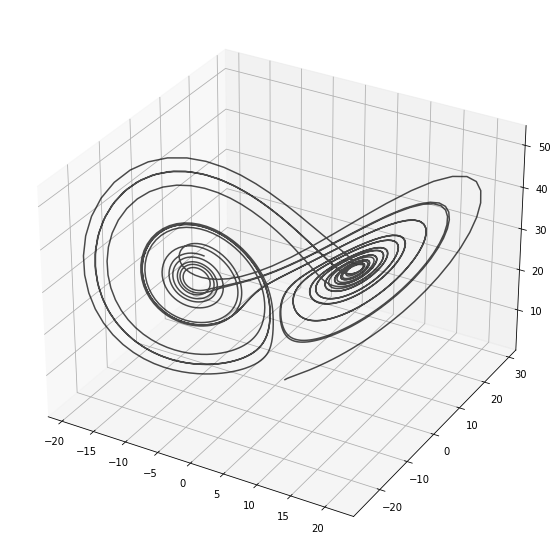

In [114]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(111, projection='3d')

plotdata = steps.to_pandas().T

ax.plot(plotdata["x"], plotdata["y"], plotdata["z"], alpha = 0.7, color = "black")
None

## Multiple initial conditions at once

In [115]:
starts = la.Dim(5, "start")

x_initial = la.Fixed(np.linspace(-2, 2, len(starts)), definition = la.Definition([starts]))
y_initial = la.Fixed(np.linspace(-2, 2, len(starts)), definition = la.Definition([starts]))
z_initial = la.Fixed(np.linspace(-2, 2, len(starts)), definition = la.Definition([starts]))

In [116]:
conditions = la.Dim(5, "condition")

sigma = la.Fixed(np.linspace(1, 20, len(conditions)), definition = la.Definition([conditions]))
beta = la.Fixed(np.linspace(1/3, 20/3, len(conditions)), definition = la.Definition([conditions]))
rho = la.Fixed(np.linspace(5, 40, len(conditions)), definition = la.Definition([conditions]))

In [117]:
x = lad.State(x_initial, definition = la.Definition([starts, conditions]), label = "x")
y = lad.State(y_initial, definition = la.Definition([starts, conditions]), label = "y")
z = lad.State(z_initial, definition = la.Definition([starts, conditions]), label = "z")

In [118]:
x.derivative = dx(y, x, sigma)
y.derivative = dy(x, y, z, rho)
z.derivative = dz(x, y, z, beta)


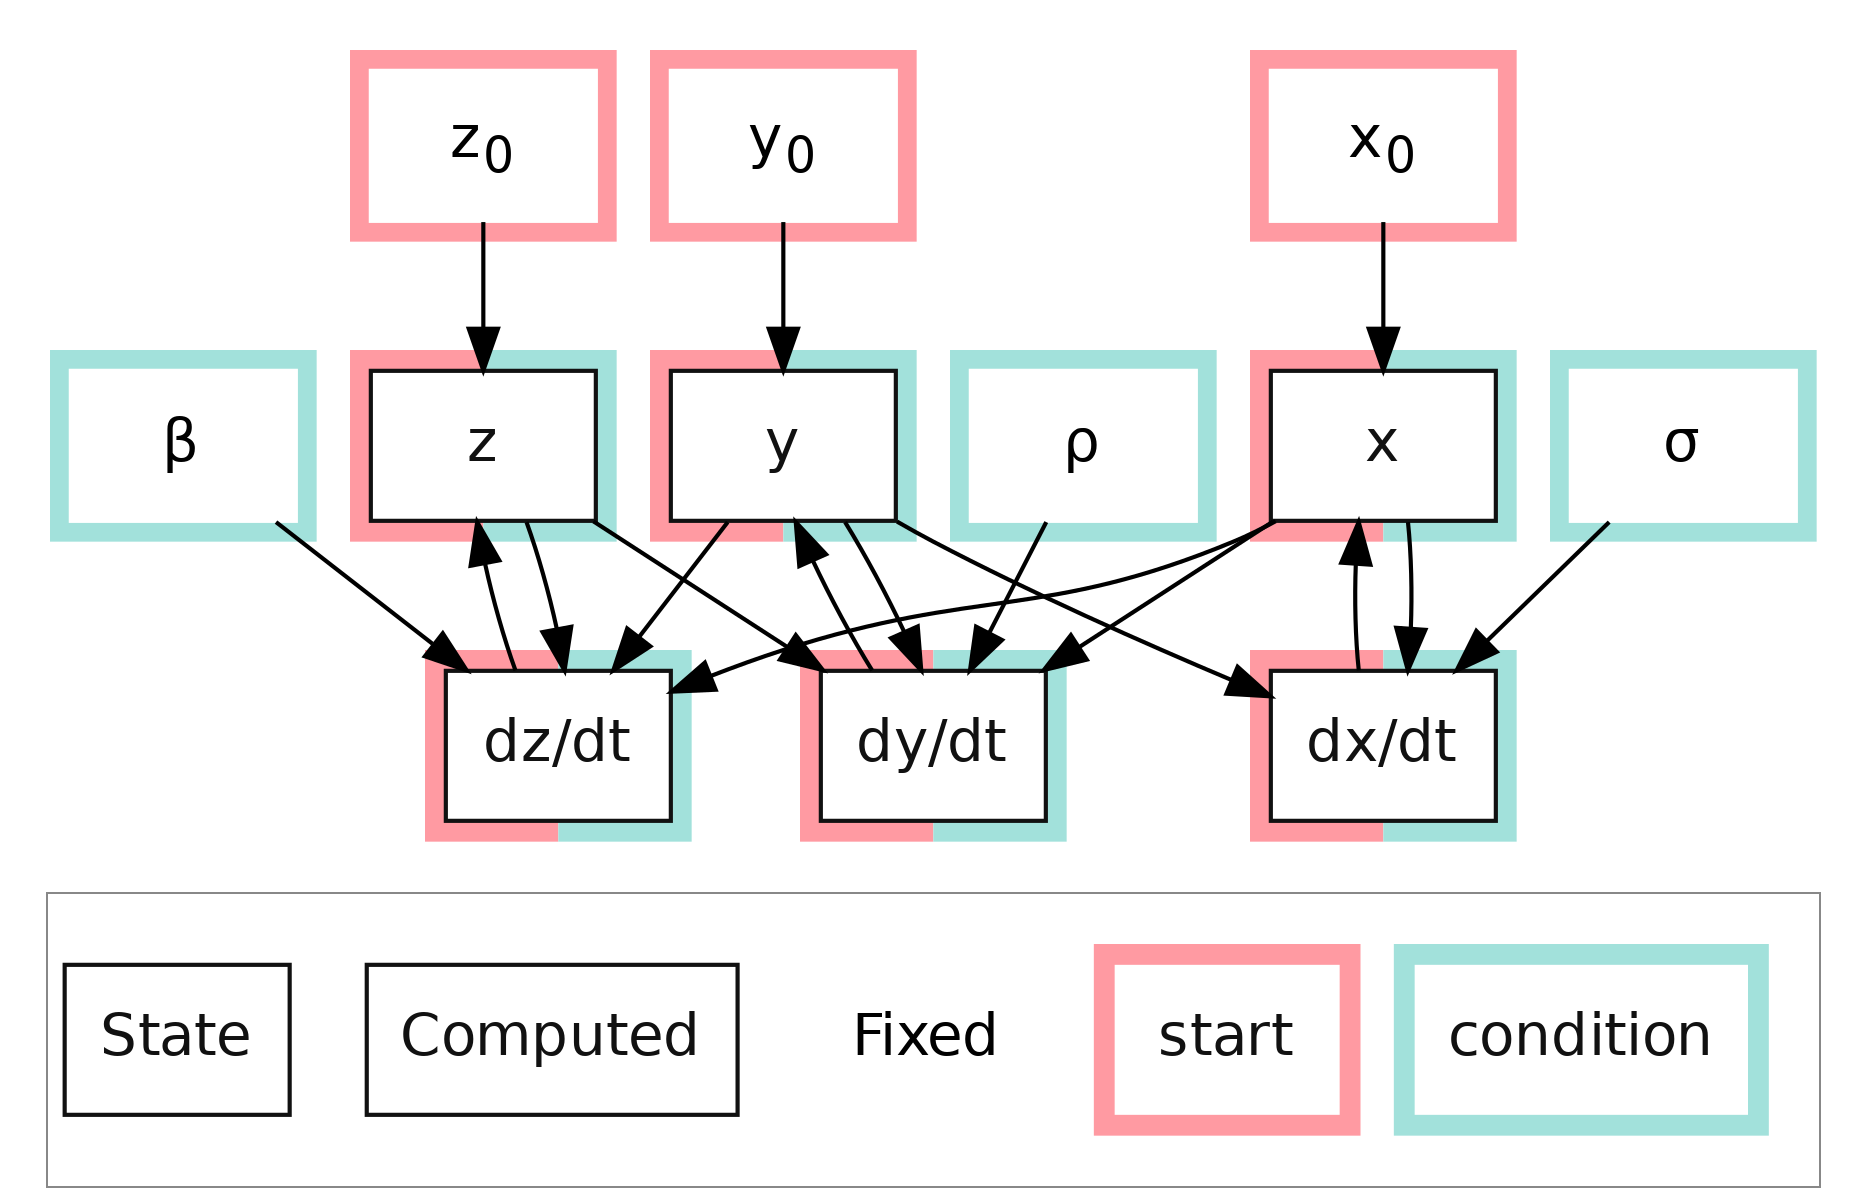

In [119]:
z.plot()

In [120]:
final_time = la.Fixed(50.)

x_extractor = lad.extractors.EachExtractor(x, final_time)
y_extractor = lad.extractors.EachExtractor(y, final_time)
z_extractor = lad.extractors.EachExtractor(z, final_time)

extractors = [x_extractor, y_extractor, z_extractor]

In [121]:
dt = la.Fixed(0.001)

In [122]:
states = [x, y, z]
dynamics = lad.solvers.Euler(states, extractors, dt)

In [123]:
time = dynamics.time
time_extractor = lad.extractors.EachExtractor(time, final_time)
dynamics.add_extractors(time_extractor)


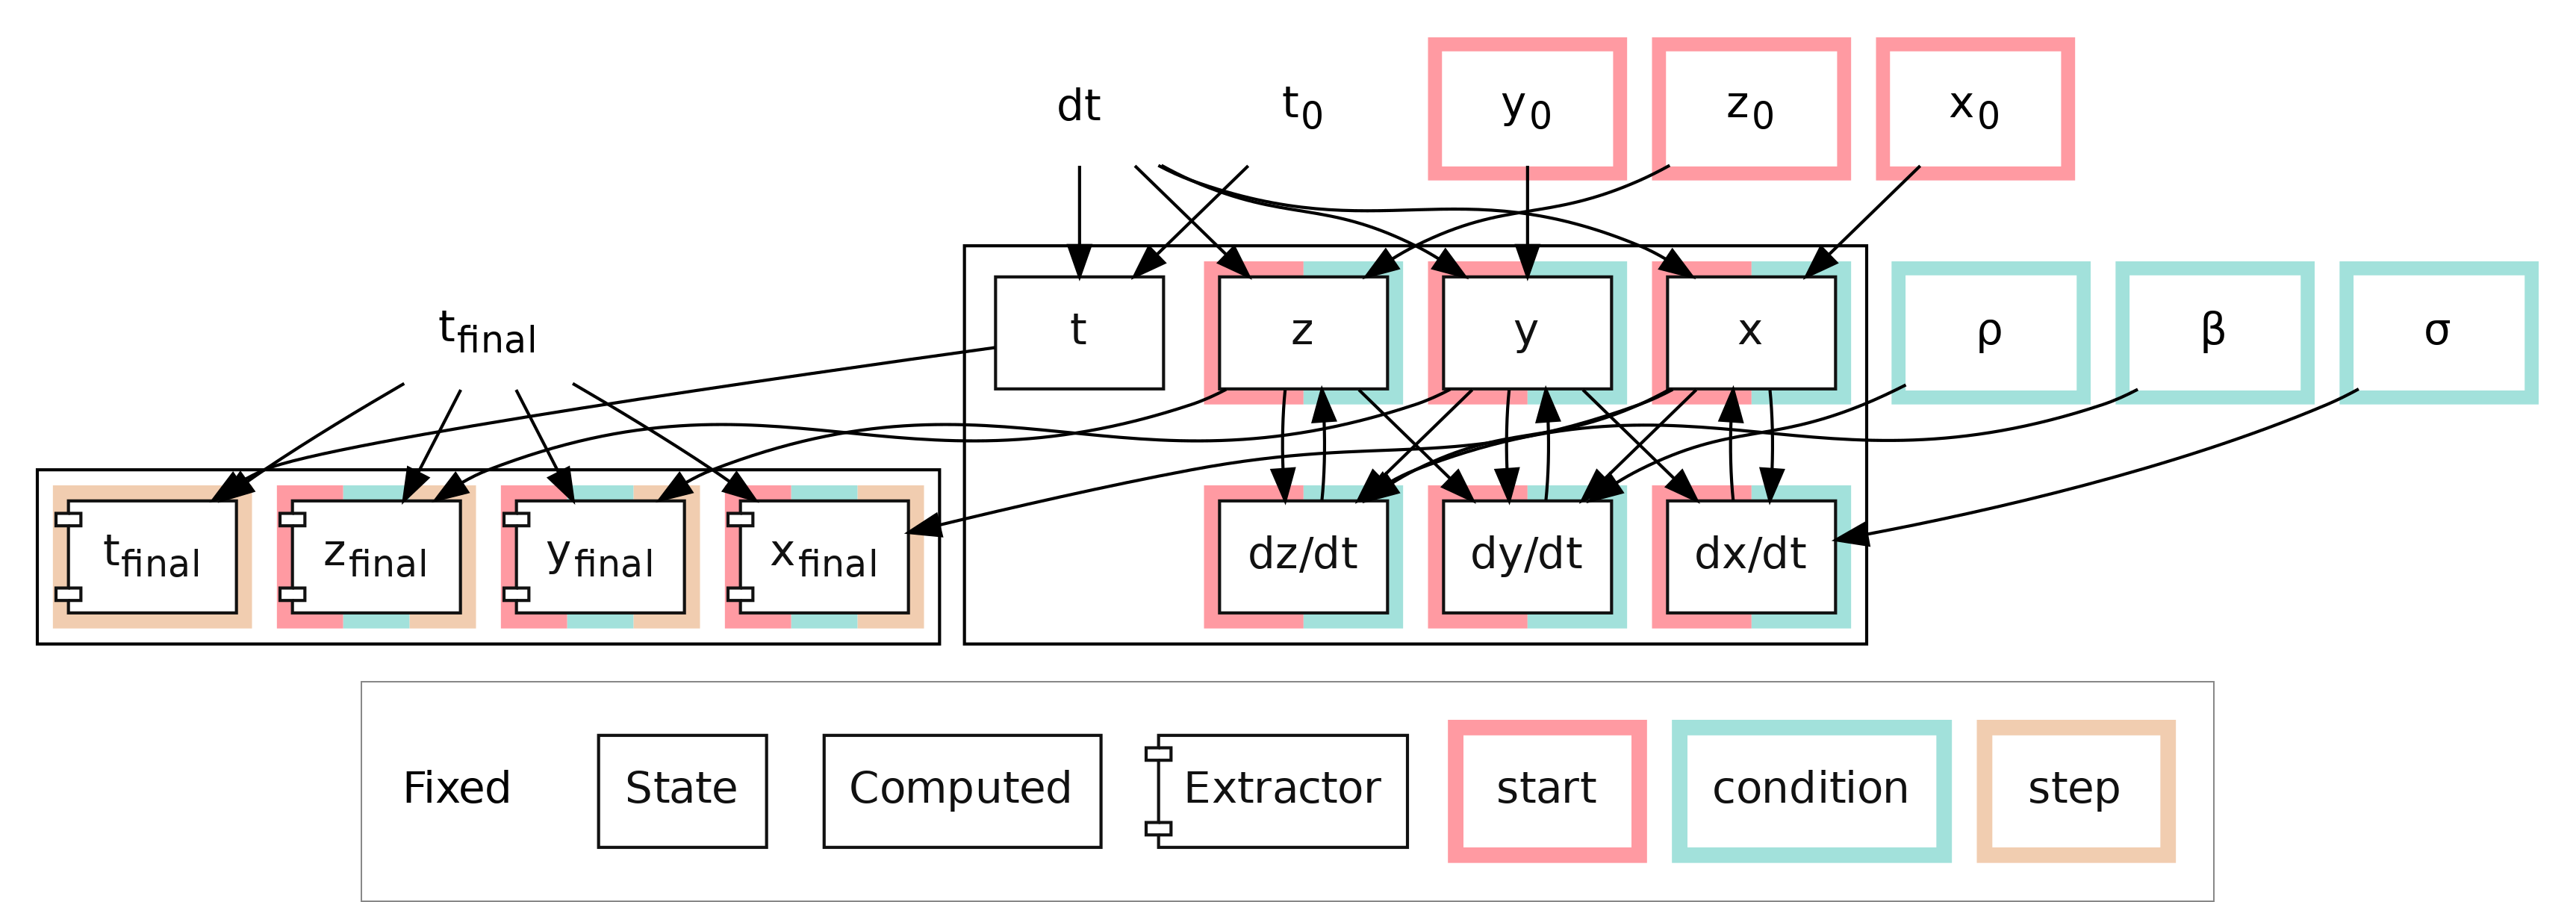

In [124]:
model = la.Model(x_extractor, y_extractor, z_extractor, time_extractor)
model.plot()

In [125]:
posterior = la.posterior.Posterior(model, batch_dim = "")
posterior.sample(1)

  0%|          | 0/1 [00:00<?, ?it/s]

In [126]:
time_values = posterior.samples[time_extractor].sel(sample = 0).broadcast_like(posterior.samples[z_extractor].sel(sample = 0))
steps = xr.concat([
    posterior.samples[x_extractor].sel(sample = 0),
    posterior.samples[y_extractor].sel(sample = 0),
    posterior.samples[z_extractor].sel(sample = 0),
    time_values
], dim = pd.Series(["x", "y", "z", "time"], name = "state"))

In [127]:
sns.set_palette("Set1", 8, .75)

In [128]:
def extract_run(start = 3, condition = 2):
    rundata = steps.sel(start = start, condition = condition).to_pandas().T
    rundata["name"] = f"start={start};condition={condition}"
    return rundata

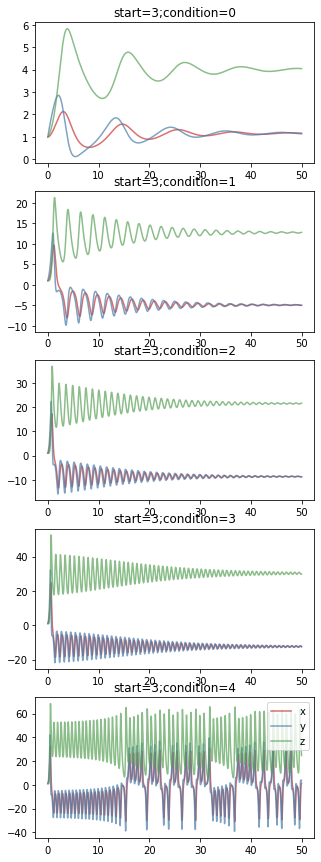

In [129]:
design = pd.DataFrame({"condition":[0, 1, 2, 3, 4], "start":3})

fig, axes = plt.subplots(design.shape[0], 1, figsize = (5, 3 * design.shape[0]))

for ax, (ix, row) in zip(axes, design.iterrows()):
    plotdata = extract_run(condition = row["condition"], start = row["start"])
    ax.plot(plotdata["time"], plotdata["x"], alpha = 0.7, label = "x")
    ax.plot(plotdata["time"], plotdata["y"], alpha = 0.7, label = "y")
    ax.plot(plotdata["time"], plotdata["z"], alpha = 0.7, label = "z")
    ax.set_title(plotdata["name"][0])
plt.legend()

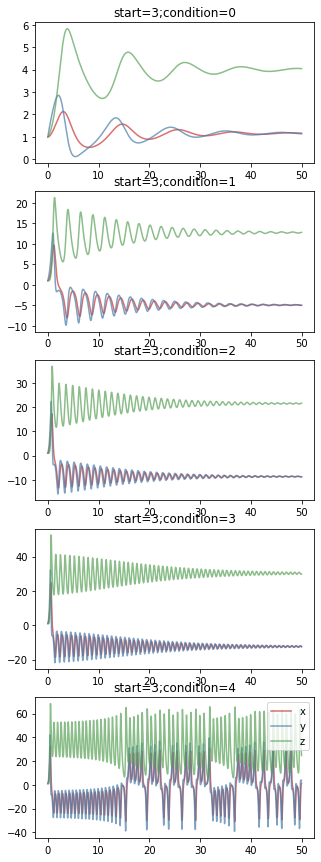

In [130]:
design = pd.DataFrame({"condition":[0, 1, 2, 3, 4], "start":3})

fig, axes = plt.subplots(design.shape[0], 1, figsize = (5, 3 * design.shape[0]))

for ax, (ix, row) in zip(axes, design.iterrows()):
    plotdata = extract_run(condition = row["condition"], start = row["start"])
    ax.plot(plotdata["time"], plotdata["x"], alpha = 0.7, label = "x")
    ax.plot(plotdata["time"], plotdata["y"], alpha = 0.7, label = "y")
    ax.plot(plotdata["time"], plotdata["z"], alpha = 0.7, label = "z")
    ax.set_title(plotdata["name"][0])
plt.legend()

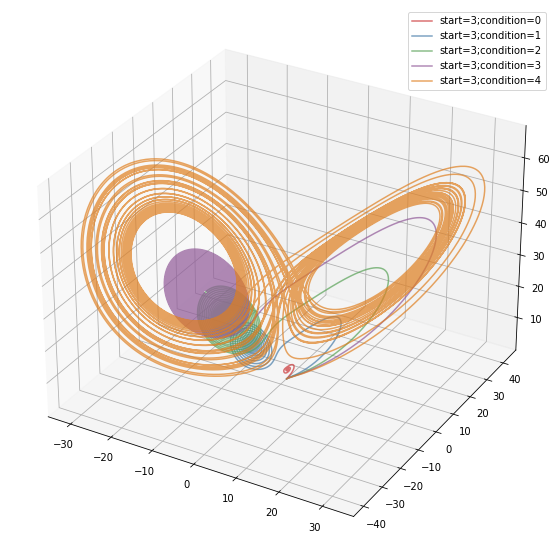

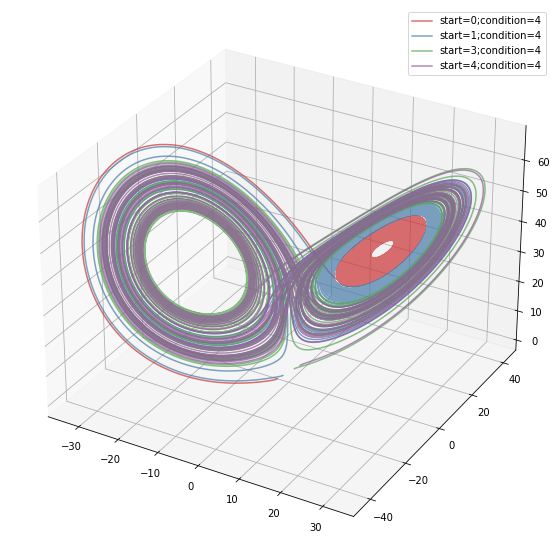

In [131]:
from mpl_toolkits.mplot3d import Axes3D

design = pd.DataFrame({"condition":[0, 1, 2, 3, 4], "start":3})

fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(111, projection='3d')

for ix, (row) in design.iterrows():
    plotdata = extract_run(condition = row["condition"], start = row["start"])
    ax.plot(plotdata["x"], plotdata["y"], plotdata["z"], alpha = 0.7, label = plotdata["name"][0])
plt.legend()


design = pd.DataFrame({"start":[0, 1, 3, 4], "condition":4})

fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(111, projection='3d')

for ix, (row) in design.iterrows():
    plotdata = extract_run(condition = row["condition"], start = row["start"])
    ax.plot(plotdata["x"], plotdata["y"], plotdata["z"], alpha = 0.7, label = plotdata["name"][0])
plt.legend()